<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >

# Pivot Tables

Essentially a *multidimensional* version of ``GroupBy`` aggregation: split and combine across a two-dimensional grid.

## Motivating Pivot Tables

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [15]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [16]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


In [17]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [18]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [19]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [20]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308  

### Additional pivot table options

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```
``aggfunc`` controls type of aggregation, default: mean.
The aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
It can be specified as a dictionary mapping a column to any of these options:

In [21]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [22]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


## Example: Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [23]:
# shell command to download the data:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [24]:
births = pd.read_csv('data/births.csv')

In [25]:
births.head()

,year,month,day,gender,births
0,1969,1,1,F,4046
1,1969,1,1,M,4440
2,1969,1,2,F,4454
3,1969,1,2,M,4548
4,1969,1,3,F,4548


In [26]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


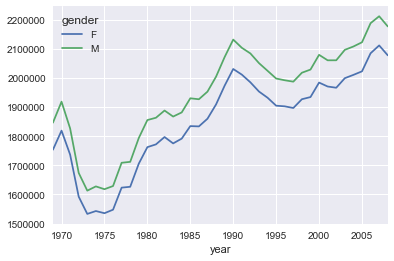

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
#plt.ylabel('total births per year');

### Further data exploration

Removing outliers:

In [28]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

In [29]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

In [30]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

In [31]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

Using this we can plot births by weekday for several decades:

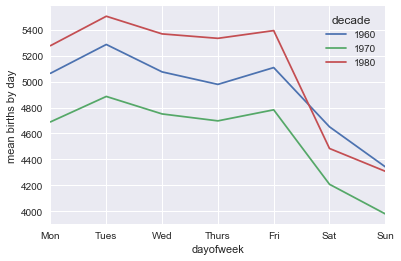

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

In [34]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [35]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


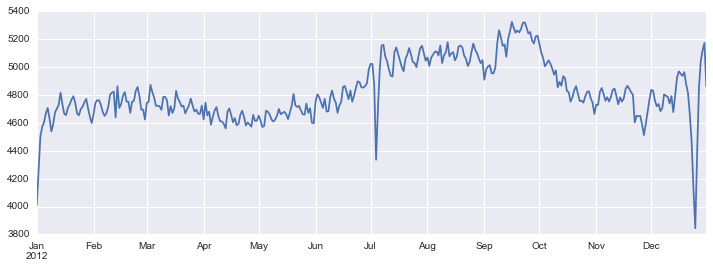

In [22]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >